In [1]:
import torch
from torch import nn
import torch.nn.functional as F


class My_Encoder(nn.Module):
    def __init__(self, dim, dim_encoder_output, activation="tanh"):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim, dim_decoder_input, activation="tanh"):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm import tqdm

from collections import OrderedDict

import matplotlib.pyplot as plt

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
x_ori = training_data.data / training_data.data.max().to(torch.float)
x_idx = torch.arange(0, len(x_ori)).to(torch.long)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, x):
        self.x = x.view(-1, 1, 28, 28)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], idx

dataloader = DataLoader(CustomImageDataset(x_ori), batch_size=128, shuffle=True)

In [7]:
model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", My_Encoder(512, 4)),
            ("decoder", My_Decoder(512, 2)),
        ]
    )
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

device = 'cpu'

for _ in tqdm(range(10)):
    for x, idx in dataloader:

        h = model.get_submodule("encoder")(x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu, device=device) * sigma + mu
        pred = model.get_submodule("decoder")(z)
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='none')
        loss = ll.sum() / len(x) + kl

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


In [13]:
model.eval()

with torch.no_grad():
    h = model.get_submodule("encoder")(x_ori)
    mu = h[:, :2]
    pred = model.get_submodule("decoder")(mu)
    h_2 = model.get_submodule("encoder")(pred)
    mu_2 = h_2[:, :2]
    ll = (mu - mu_2).square().sqrt().sum(dim=1)

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx[n_ll > 4]
    print(outliers.shape)

torch.Size([39])


In [11]:
def show_images(images, indices):
    nr = len(indices) // 10 + 1
    imgs = images[indices]
    imgs = torch.cat([imgs, torch.ones(nr * 10 - len(imgs), 28, 28)])

    _, axs = plt.subplots(nr, 10, figsize=[20, 2 * nr])
    
    for ax, img in zip(axs.flat, imgs):
        ax.imshow(img, cmap='gray', vmax=1, vmin=0)
        ax.axis('off')
    plt.tight_layout()


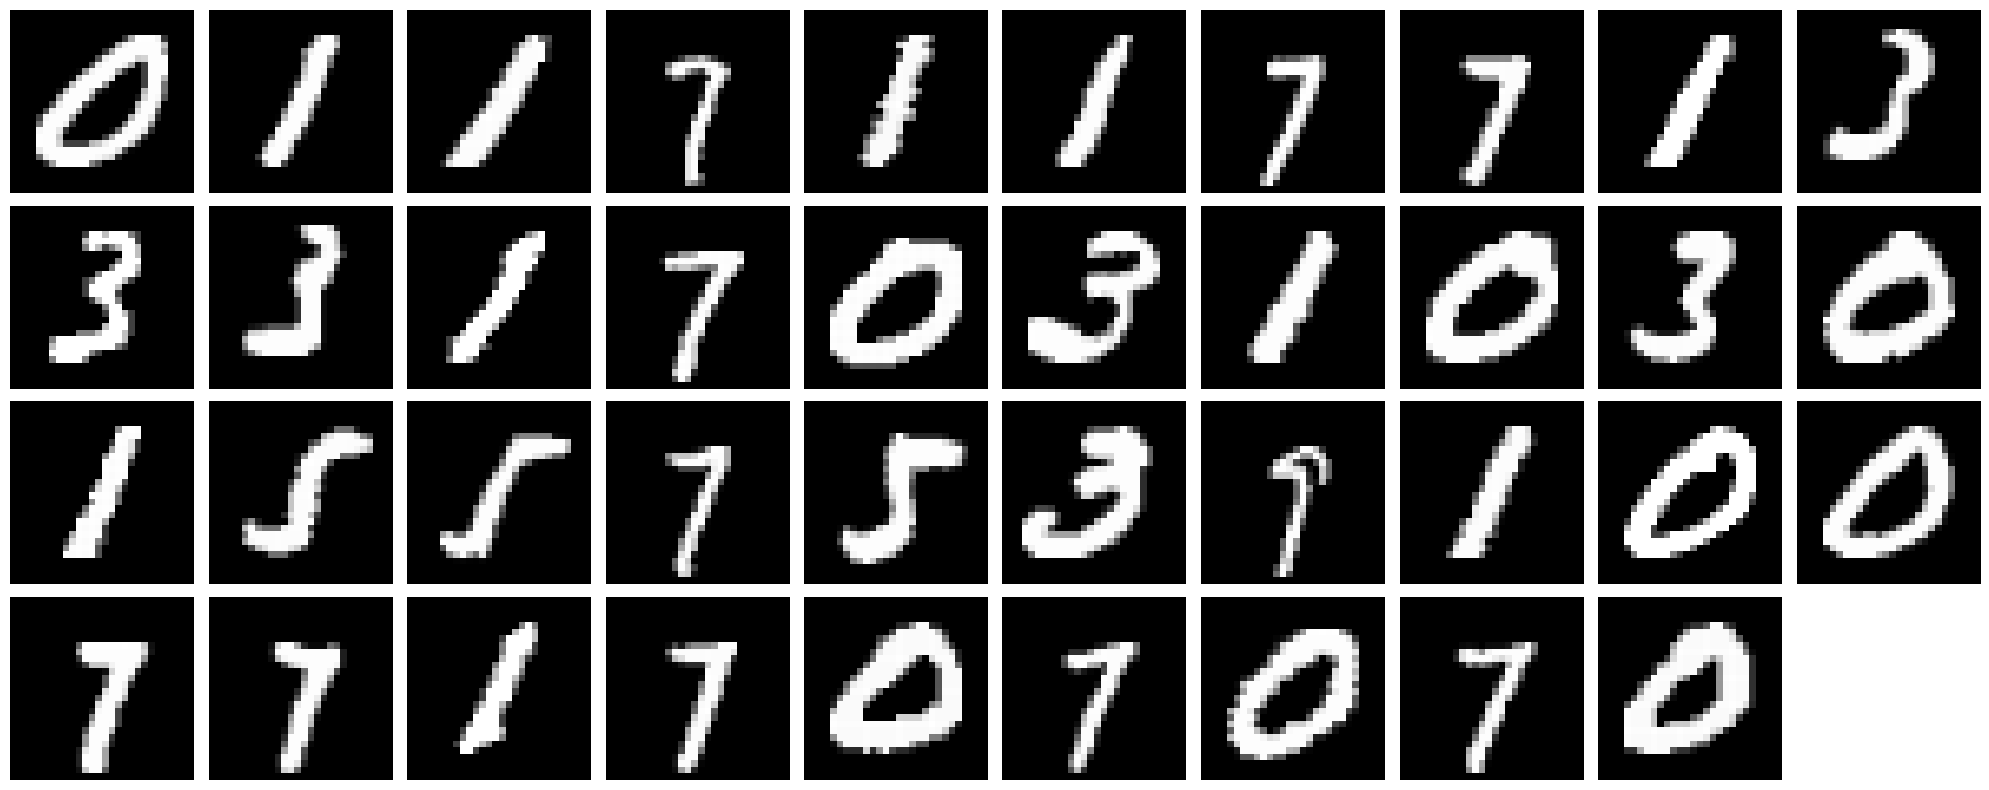

In [14]:
show_images(x_ori, outliers)

In [31]:
model.eval()

with torch.no_grad():
    h = model.get_submodule("encoder")(x_ori)
    mu = h[:, :2]
    pred = model.get_submodule("decoder")(mu)
    h_2 = model.get_submodule("encoder")(pred)
    mu_2 = h_2[:, :2]
    ll = F.cosine_similarity(mu, mu_2, dim=1)
    # ll = (mu - mu_2).square().sqrt().sum(dim=1)

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx[n_ll > 0.36]
    print(outliers.shape)

torch.Size([3109])
